In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

In [ ]:
from tensorflow import keras

datagen = keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)

In [ ]:
train_aug = datagen.flow_from_directory('/content/awe_training', seed=100, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, subset="training")
val_aug = datagen.flow_from_directory('/content/awe_training', seed=100, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, subset="validation")

Found 720 images belonging to 80 classes.
Found 80 images belonging to 80 classes.


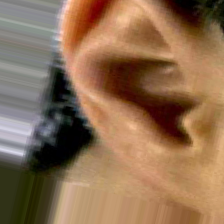

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
def skl(dataset):
  for data in dataset:
    return data[0][0]
array_to_img(skl(train_aug))

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback

In [ ]:
class MobileModel():
  def __init__(self, image_dimensions=(224,224 ,3), n_classes=100):
    self.n_classes = n_classes  # number of classes to classify
    self.input_dim = image_dimensions  # image input dimensions
    self.model = self.create_model()  # model

  def summary(self):
    self.model.summary()

  def create_model(self):
    self.base_model = keras.applications.MobileNetV3Large(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3),
        include_top=False,
        pooling=None)
    
    self.base_model.trainable = False

    inputs = keras.Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))

    #x = data_augmentation(inputs)
    x = keras.applications.mobilenet_v3.preprocess_input(inputs)
    x = self.base_model(x, training=False)
    #x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)

    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
    #x = keras.layers.Dense(1280, activation='relu')(x)

    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
    #x = keras.layers.Dense(1280, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(self.n_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    return model


  def train(self, train_data, val_data, plot_results=True, epochs=10):
    'Trains classifier part of the model with data from generators'
    print("Starting training")

    # reduces learning rate if no improvement are seen
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=1,
                                                verbose=0,
                                                factor=0.2,
                                                min_lr=0.000001)

    # stop training if no improvements are seen
    early_stop = EarlyStopping(monitor="val_loss",
                              mode="min",
                              patience=3,
                              restore_best_weights=True)

    # saves model weights to file
    checkpoint = ModelCheckpoint('/content/models//model_weights.hdf5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                mode='min',
                                save_weights_only=True)

    # visualize training data
    # tensorboard = TensorBoard(log_dir='./logs',
    #                          histogram_freq=0,
    #                          batch_size=BATCH_SIZE,
    #                          write_graph=True,
    #                          write_grads=True,
    #                          write_images=False)

    # train on data
    self.model.compile(optimizer=keras.optimizers.Adam(0.002),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    history = self.model.fit(
                  train_data,
                  validation_data=val_data,
                  epochs=epochs,
                  validation_steps=len(val_data),
                  steps_per_epoch=len(train_data),
                  callbacks=[learning_rate_reduction, early_stop, checkpoint],
                  verbose=1,
                  )
    # plot training history
    if plot_results:
      fig, ax = plt.subplots(2, 1, figsize=(6, 6))
      ax[0].plot(history.history['loss'], label="TrainLoss")
      ax[0].plot(history.history['val_loss'], label="ValLoss")
      ax[0].legend(loc='best', shadow=True)

      ax[1].plot(history.history['accuracy'], label="TrainAcc")
      ax[1].plot(history.history['val_accuracy'], label="ValAcc")
      ax[1].legend(loc='best', shadow=True)

      plt.show()

  def finetune(self, finetune_data, val_data, plot_results=True, epochs=10):
    'Finetunes whole model with data from generators'
    print("Starting finetuning")

    # reduces learning rate if no improvement are seen
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=1,
                                                verbose=0,
                                                factor=0.2,
                                                min_lr=1e-7)

    # stop training if no improvements are seen
    early_stop = EarlyStopping(monitor="val_loss",
                              mode="min",
                              patience=3,
                              restore_best_weights=True)

    # saves model weights to file
    checkpoint = ModelCheckpoint('/content/models/finetuned_model_weights.hdf5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                mode='min',
                                save_weights_only=True)

    self.base_model.trainable = True
    self.model.summary()

    self.model.compile(optimizer=keras.optimizers.Adam(5e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
    history = self.model.fit(
                  finetune_data,
                  validation_data=val_data,
                  epochs=epochs,
                  validation_steps=len(val_data),
                  steps_per_epoch=len(finetune_data),
                  callbacks=[learning_rate_reduction, early_stop, checkpoint],
                  verbose=1,
                  )
    
    # plot training history
    if plot_results:
      fig, ax = plt.subplots(2, 1, figsize=(6, 6))
      ax[0].plot(history.history['loss'], label="TrainLoss")
      ax[0].plot(history.history['val_loss'], label="ValLoss")
      ax[0].legend(loc='best', shadow=True)

      ax[1].plot(history.history['accuracy'], label="TrainAcc")
      ax[1].plot(history.history['val_accuracy'], label="ValAcc")
      ax[1].legend(loc='best', shadow=True)

      plt.show()

  def load_weights_from_checkpoint(self):
    self.model.load_weights('/content/models/model_weights.hdf5')
  
  def evaluate(self, data):
    scores = self.model.evaluate(data)
    print('Loss: %.3f' % scores[0])
    print('accuracy: %.3f' % scores[1])

In [ ]:
model = MobileModel(n_classes=80)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 80)                102480    
                                                                 
Total params: 4,328,912
Trainable params: 102,480
Non-trainable params: 4,226,432
___________________________________________

Starting training
Epoch 1/150
12/12 [==============================] - 20s 1s/step - loss: 5.1919 - accuracy: 0.0139 - val_loss: 4.3462 - val_accuracy: 0.0125 - lr: 0.0020
Epoch 2/150
12/12 [==============================] - 13s 1s/step - loss: 4.3781 - accuracy: 0.0472 - val_loss: 4.1944 - val_accuracy: 0.1375 - lr: 0.0020
Epoch 3/150
12/12 [==============================] - 13s 1s/step - loss: 3.8165 - accuracy: 0.1208 - val_loss: 4.0089 - val_accuracy: 0.0875 - lr: 0.0020
Epoch 4/150
12/12 [==============================] - 13s 1s/step - loss: 3.3721 - accuracy: 0.2014 - val_loss: 3.7980 - val_accuracy: 0.1125 - lr: 0.0020
Epoch 5/150
12/12 [==============================] - 13s 1s/step - loss: 3.1327 - accuracy: 0.2319 - val_loss: 3.6541 - val_accuracy: 0.2125 - lr: 0.0020
Epoch 6/150
12/12 [==============================] - 13s 1s/step - loss: 2.7762 - accuracy: 0.3014 - val_loss: 3.6463 - val_accuracy: 0.2000 - lr: 0.0020
Epoch 7/150
12/12 [==============================] - 12s 1

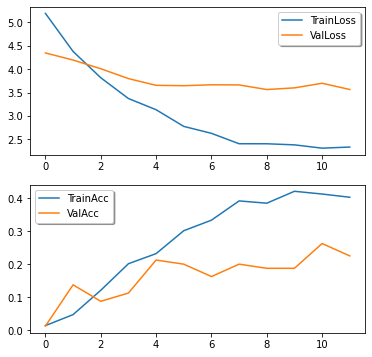

In [ ]:
# train model
model.train(train_aug, val_aug, plot_results=True, epochs=150)

In [ ]:
# Evaluate the model
scores = model.evaluate(val_aug)

2/2 [==============================] - 1s 202ms/step - loss: 3.6891 - accuracy: 0.1625
Loss: 3.689
accuracy: 0.162


In [ ]:
model.model.save("/content/models/model_nofinetuning.h5", save_format="h5")
model.model.save("/content/models/model_nofinetuning", save_format="tf")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: /content/models/model_nofinetuning/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
!tar -czvf model.tar.gz /content/models/

tar: Removing leading `/' from member names
/content/models/
/content/models/model_weights.hdf5
/content/models/model_nofinetuning.h5
/content/models/model_nofinetuning/
/content/models/model_nofinetuning/assets/
/content/models/model_nofinetuning/variables/
/content/models/model_nofinetuning/variables/variables.data-00000-of-00001
/content/models/model_nofinetuning/variables/variables.index
/content/models/model_nofinetuning/keras_metadata.pb
/content/models/model_nofinetuning/saved_model.pb


In [ ]:
finetuned_model = MobileModel(n_classes=80)

Starting finetuning
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 80)                102480    
                                                                 
Total params: 4,328,912
Trainable params: 4,304,512
Non-trainable params: 24,400
________________________

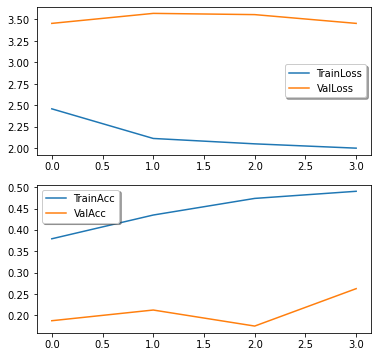

In [ ]:
finetuned_model.load_weights_from_checkpoint()
finetuned_model.finetune(train_aug, val_aug, epochs=150)

In [ ]:
# Evaluate the model
scores = finetuned_model.evaluate(val_aug)

2/2 [==============================] - 1s 193ms/step - loss: 3.6402 - accuracy: 0.2000
Loss: 3.640
accuracy: 0.200


In [ ]:
feature_extractor = keras.Model(
    inputs=finetuned_model.model.input,
    outputs=finetuned_model.model.get_layer(index=2).output,
)
feature_extractor.trainable = False

feature_extractor.compile(optimizer=keras.optimizers.Adam(0.02),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

feature_extractor.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
Total params: 4,226,432
Trainable params: 0
Non-trainable params: 4,226,432
_________________________________________________________________
